<h1>The5Outliers - <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span>: why so many players pass through World regions to reach their target</h1>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import plotly.graph_objects as go

import config
from src.utils.HTMLParser import HTMLParser
from src.data.data_loader import *
from src.utils.helpers import *
from src.models.networks import *
from src.models.similarity_matrices import *

parser = HTMLParser()
parser.load_pickle()

In [3]:
# Delete for final version?
# Compute and save all embending, similarity matrices and parsed articles
#compute_save_all()

# 0. Data preprocessing and loading

We use the `read_all()` function to load, clean, and enhance the data with useful features for analysis. It combines multiple data sources, performs preprocessing, and computes additional features for articles and user paths.

## Preprocessed Dataframes:

- `df_article_names`: Valid article names, that is without special characters and discardig any invalid articles (e.g. non-Wikispeedia articles or with missing categories).
- `df_html_stats`: Gathers wikispedia page statistics like number of links, link density, and structural information from the HTML version of each article.
- `df_categories`: Article categories and sub categories.
- `df_links`: Links inward and outward between articles.
- `df_shortest_path_length`: Matrix of shortest paths lengths possible between two articles.
- `df_unfinished` and `df_finished`: Cleaned paths with computed features.
- `df_sm` and `df_scat`: Matrices for semantic and category similarity.
- `df_article`: Dataframe with article-level features.

In [4]:
# Load and preprocess the data
df_article_names, df_html_stats, df_categories, df_links, df_shortest_path, df_unfinished, df_finished, df_sm, df_scat, df_article = read_all()

Unfinished Paths
---------------- 
Number of rows before filtering: 24875
Invalid target articles found: {'Rss', 'Great', ' Zebra', 'Christmas', 'Fats', 'The Rock', 'Test', 'Bogota', 'Adolph Hitler', 'Rat', 'Usa', 'Podcast', 'Charlottes web', 'Macedonia', 'Kashmir', 'Sportacus', 'Black ops 2', 'Mustard', 'Netbook', 'Georgia', 'Western Australia', 'English', 'The', 'Pikachu', 'Long peper'}
Invalid articles found in path: {'Local community', 'Osteomalacia', 'Wikipedia Text of the GNU Free Documentation License', 'Private Peaceful', 'Pikachu'}
Number of 'timeout' games with a duration of less than 30 minutes: 7
Number of rows after filtering: 24709 

Finished Paths
-------------- 
Number of rows before filtering: 51318
Invalid articles found in path: {'Pikachu', 'Osteomalacia', 'Wikipedia Text of the GNU Free Documentation License', 'Local community'}
Number of rows after filtering: 51196


## Key Modifications

### 1. Categories:
Some articles belong to multiple categories. For our analysis we need to have only one category corresponding to each article, thus we choose to keep the most specific one. We will explain later (3.3) what filtering the most specific category really means.

### 2. Article Features:
- **In-Degree**: of an article corresponds to the number of links on other pages targetting an article 
    - Some articles have no articles leading to it.
- **Out-Degree**: of an article corresponds to the number of links towards other pages on this article
    - Some articles lead to no other articles.
- **HTML Stats**: Structural details like the number of links per article.
    - Links do not consider duplicates inside the page (each link is considered to appear once) but this is relaxed with the HTML parsing.
- **Categories**: Assigns the most specific category to each article.

### 3. Path Features:
Metrics computed for user navigation paths:

- **Path Length**: Number of articles in a user's path.
- **Back-Clicks**: How many times users revisit previous articles.
- **Cosine Similarity**: Semantic similarity between source and target articles.
- **Shortest Path**: Length of the shortest path possible between the source and target articles.
- **Category Similarity**: Category similarity between the categories of the source and target articles.

## 1 Find Voyages

The goal of our research is to explore the role and significance of world regions in user behavior while playing Wikispeedia. To achieve this, we first extract articles corresponding to *World Regions*.  
Fortunately, articles are categorized, so we gather those under *'Countries'* and relevant subcategories of *'Geography'* such as *'Geography of Asia'*. These articles are grouped into a new category called *'Voyages'*, while remaining *'Geography'* articles are keeping the same category.

A <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyage</span> is defined as a path game where neither the source nor the target is in **World Region**, but the path includes at least one article from this category.

In [5]:
world_regions_categories = ['Geography of Great Britain', 'Geography of Asia', 'Geography of Oceania Australasia', 'North American Geography', 'European Geography', 'African Geography', 'Central and South American Geography', 'Antarctica', 'Geography of the Middle East', 'African Countries', 'Countries']
df_categories = assign_world_region_categories(df_categories, world_regions_categories)

### Sort games into voyage or not-voyage & assign the new category *'World Regions'*

In [6]:
# Sort paths into voyage and non-voyage
df_finished = game_voyage_sorting(df_finished, df_categories)
df_unfinished = game_voyage_sorting(df_unfinished, df_categories)

# Assign the categories "World Regions" to the concerned articles
category_map = dict(zip(df_categories["article"], df_categories["level_1"]))
df_article["category"] = df_article["article"].map(category_map)

In [7]:
# Sort paths into voyage and non-voyage
df_finished = game_voyage_sorting(df_finished, df_categories)
df_unfinished = game_voyage_sorting(df_unfinished, df_categories)

# Count the voyages 
voyage_count = (df_finished['Wikispeedia_Voyage'] == 1).sum() + (df_unfinished['Wikispeedia_Voyage'] == 1).sum()
non_voyage_count = (df_finished['Wikispeedia_Voyage'] == 0).sum() + (df_unfinished['Wikispeedia_Voyage'] == 0).sum()

print('Out of the ', len(df_finished)+len(df_unfinished), ' finished and unfinished games : ')
print('  - ', voyage_count, ' are voyages')
print('  - ', non_voyage_count, ' are not')

Out of the  75905  finished and unfinished games : 
  -  26052  are voyages
  -  49853  are not


We immediately see that <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyage</span> are very commun since they are approximately one third of the paths.

In [8]:
#concatenate all games in a dataframe and plot the sankey diagram 
df_merged = pd.concat([df_finished, df_unfinished], ignore_index=True, sort=False)
sankey_fig = plot_sankey_voyage(df_merged)

In [9]:
sankey_fig.write_html('figures/sankey.html',include_plotlyjs=False)

In [10]:
import plotly.io 

plotly.io.to_html(sankey_fig, include_plotlyjs=False)

'<html>\n<head><meta charset="utf-8" /></head>\n<body>\n    <div>                            <div id="4ffd5bcf-1bac-419c-a0d6-b188a544a79f" class="plotly-graph-div" style="height:100%; width:100%;"></div>            <script type="text/javascript">                                    window.PLOTLYENV=window.PLOTLYENV || {};                                    if (document.getElementById("4ffd5bcf-1bac-419c-a0d6-b188a544a79f")) {                    Plotly.newPlot(                        "4ffd5bcf-1bac-419c-a0d6-b188a544a79f",                        [{"link":{"color":"rgba(60,60,60,0.3)","hovercolor":["rgba(75, 75, 75, 0.3)","rgba(75, 75, 75, 0.3)","rgba(44, 181, 174, 0.3)","rgba(75, 75, 75, 0.3)","rgba(75, 75, 75, 0.3)","rgba(44, 181, 174, 0.3)"],"source":[1,1,3,2],"target":[3,2,5,5],"value":[49853,26052,49853,26052]},"node":{"color":["#2CB5AE","#4b4b4b","#2CB5AE","#4b4b4b","#2CB5AE","#4b4b4b"],"label":["Source is a World Region","Source is not a World Region","Voyages","Non Voyages","Targ

# 3. Core results

## 3.1. Article features

### 3.1.a. Distributions of words, links, and categories in articles

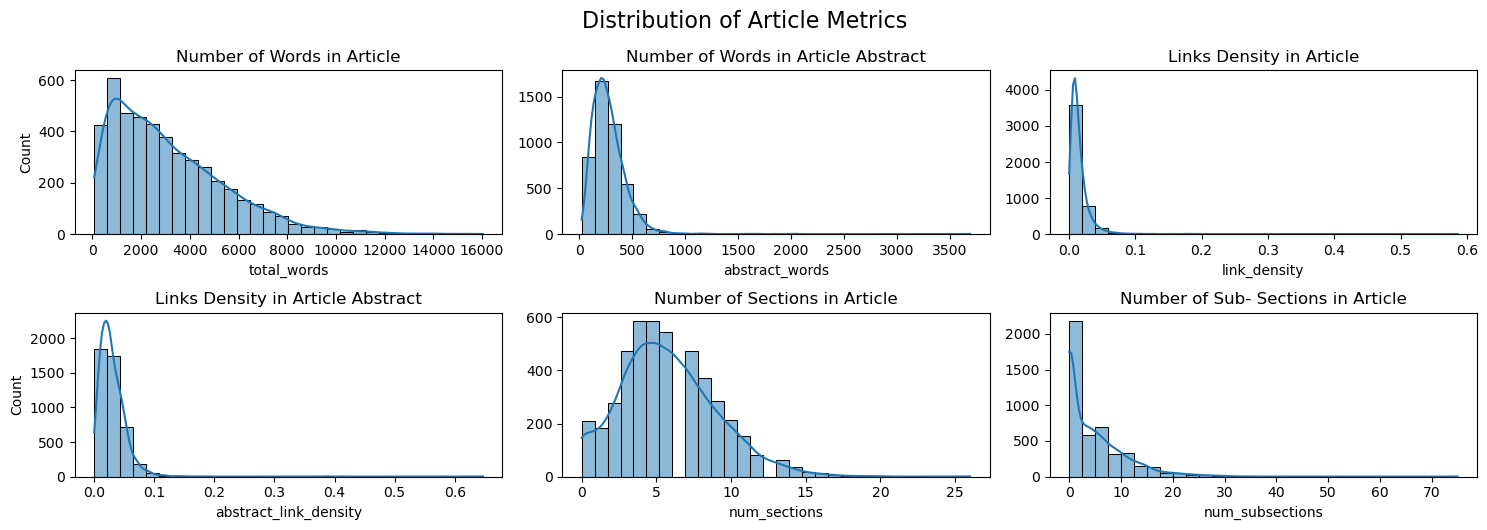

In [13]:
#TODO: big big plot voyage/non-voyage

metrics = [
    ("total_words", "Number of Words in Article"),
    ("abstract_words", "Number of Words in Article Abstract"),
    ("link_density", "Links Density in Article"),
    ("abstract_link_density", "Links Density in Article Abstract"),
    ("num_sections", "Number of Sections in Article"),
    ("num_subsections", "Number of Sub- Sections in Article")
]

fig, ax = plt.subplots(2, 3, figsize=(15, 5))

# Loop through metrics to create histograms
for i, (metric, title) in enumerate(metrics):
    row, col = divmod(i, 3)
    sn.histplot(df_article, x=metric, bins=30, kde=True, ax=ax[row, col])
    ax[row, col].set_title(title)
    if col == 1 or col == 2:
        ax[row, col].set_ylabel('')

plt.tight_layout()
plt.suptitle("Distribution of Article Metrics", y=1.05, fontsize=16)
plt.show()

Results : The data is right-skewed for most of metrics, indicating that while most articles adhere to certain standards of complexity and length, a small subset stands out as particularly detailed or interconnected.

### 3.1.b Articles Complexity

Which categories feature the most complex articles? To answer this question, let’s identify the most complex articles and the categories they belong to. We define complexity based on factors such as the number of words, links, and sections within each article.

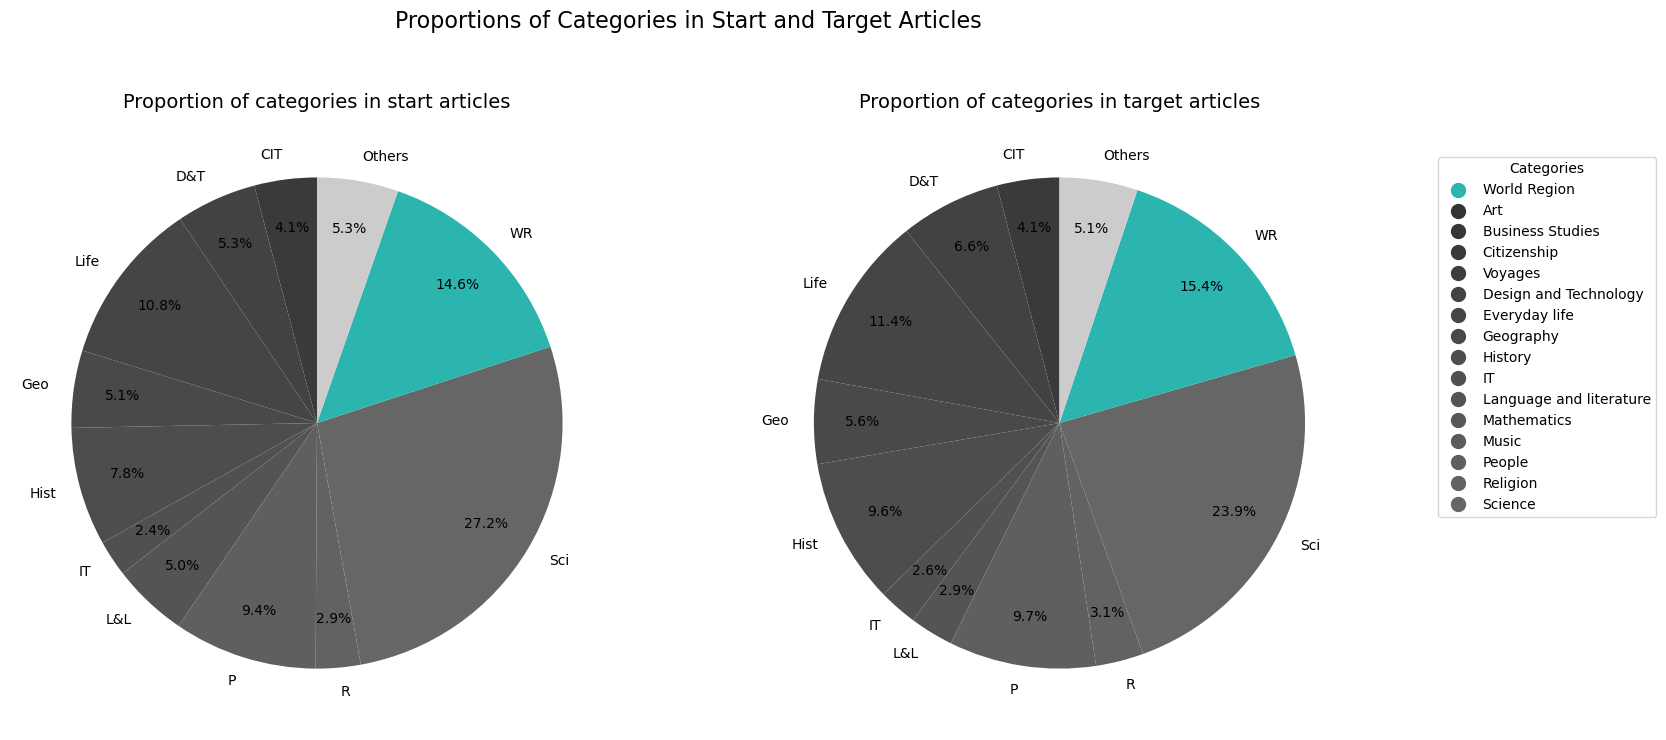

In [14]:
#add count of start and target in df_articles
count_start_and_target_per_articles(df_finished, df_unfinished, df_article)

#plot 
plot_proportion_category_start_stop_pies(
    df_article=df_article,
    palette=config.PALETTE_CATEGORY_DICT,
    abbreviations=config.CATEGORY_ABBREVIATIONS,
    threshold=2.3
)

"Science" and "World Regions" categories are the most prevalent categories in both start and end articles, indicating their significant representation.

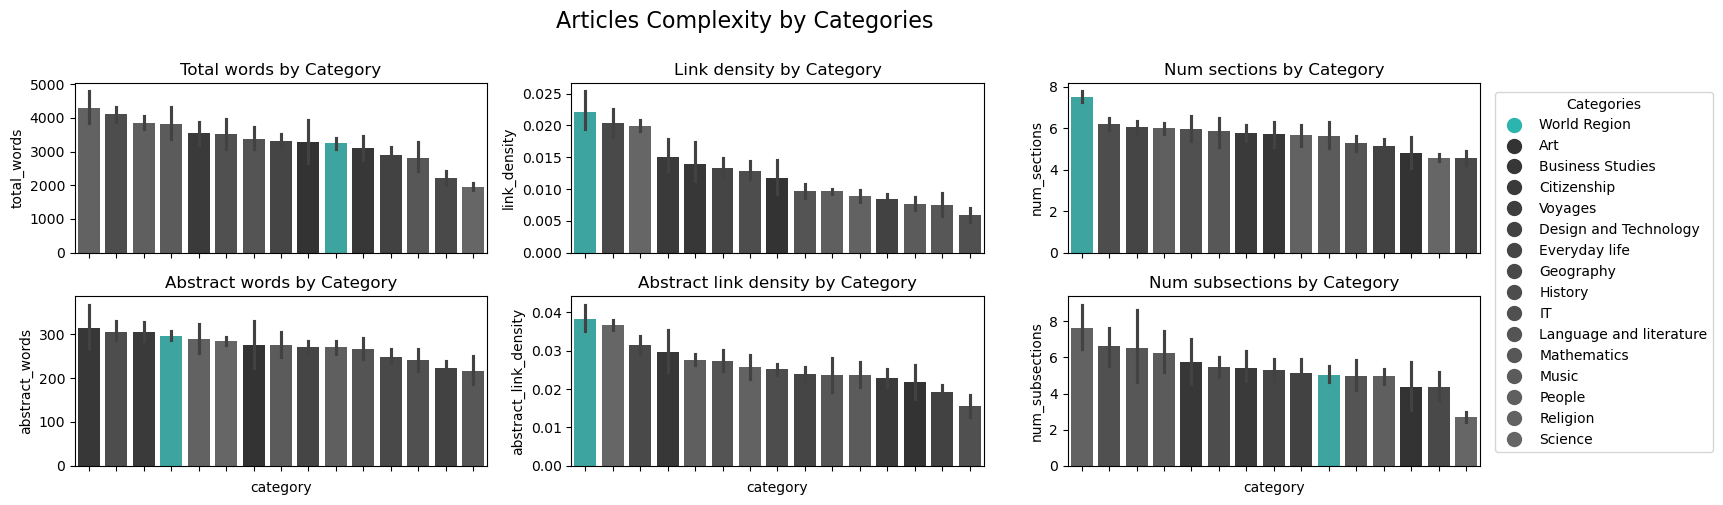

In [15]:
metrics = [
    "total_words", "link_density", "num_sections",
    "abstract_words", "abstract_link_density", "num_subsections"
]

plot_metrics_by_category(df_article, metrics, config.PALETTE_CATEGORY_DICT, config.CATEGORY_ABBREVIATIONS)

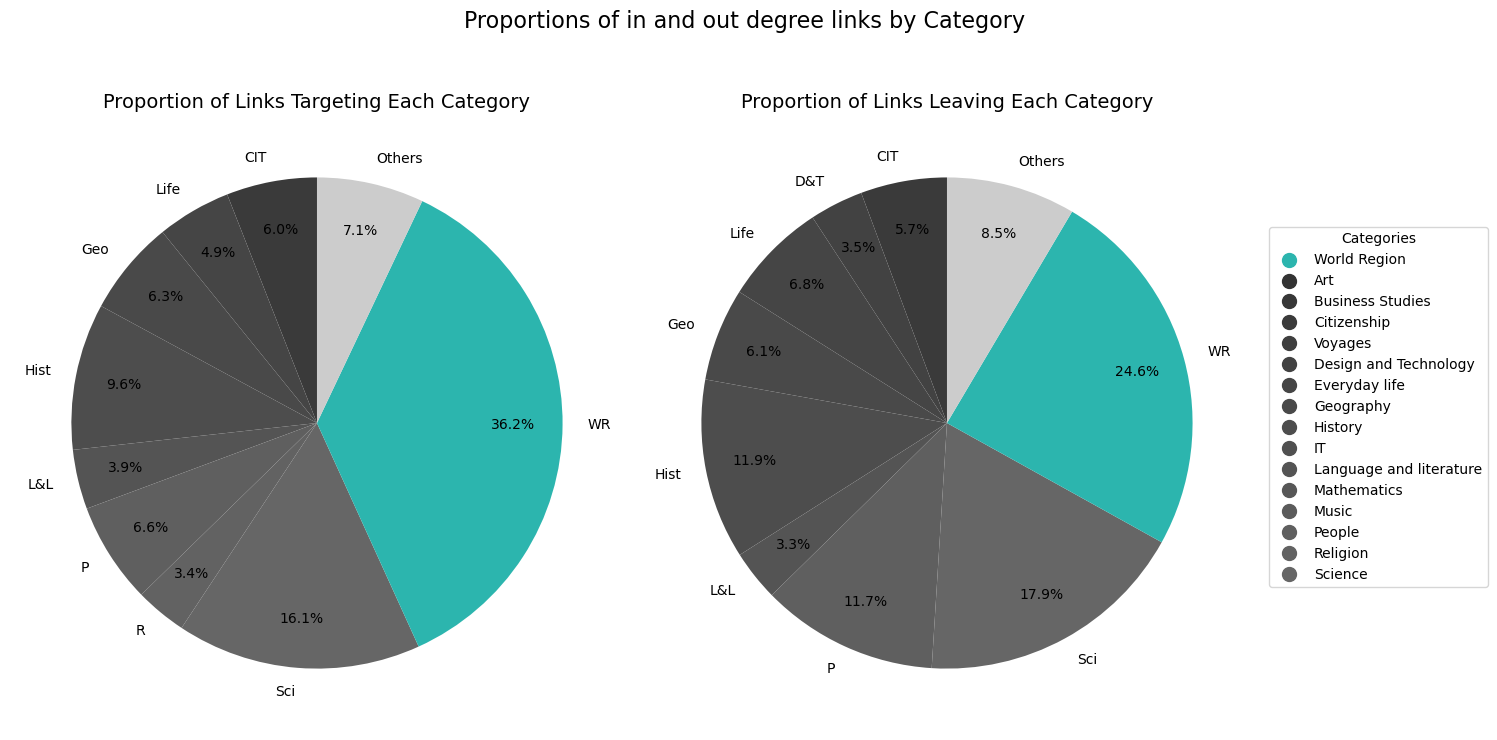

In [16]:
plot_proportions_of_in_and_out_degree_in_categories(
    df=df_article,
    palette=config.PALETTE_CATEGORY_DICT,
    abbreviations=config.CATEGORY_ABBREVIATIONS
)

World Regions articles are highly represented in the network, being the category with the highest number of incoming and outgoing links.

Results : The category "World Regions" stands out as a particularly complex topic, characterized by articles with the highest link density and the greatest number of category levels.

### 3.1.c Articles Popularity and Connectivity

Is there a correlation between the number of links in an article and the frequency with which people interact with it in the game? Does this depend more on the in-degree or out-degree of the links? And is there a significant difference between the in-degree and out-degree of links? We will compare and investigate these factors to understand their impact on article interaction.

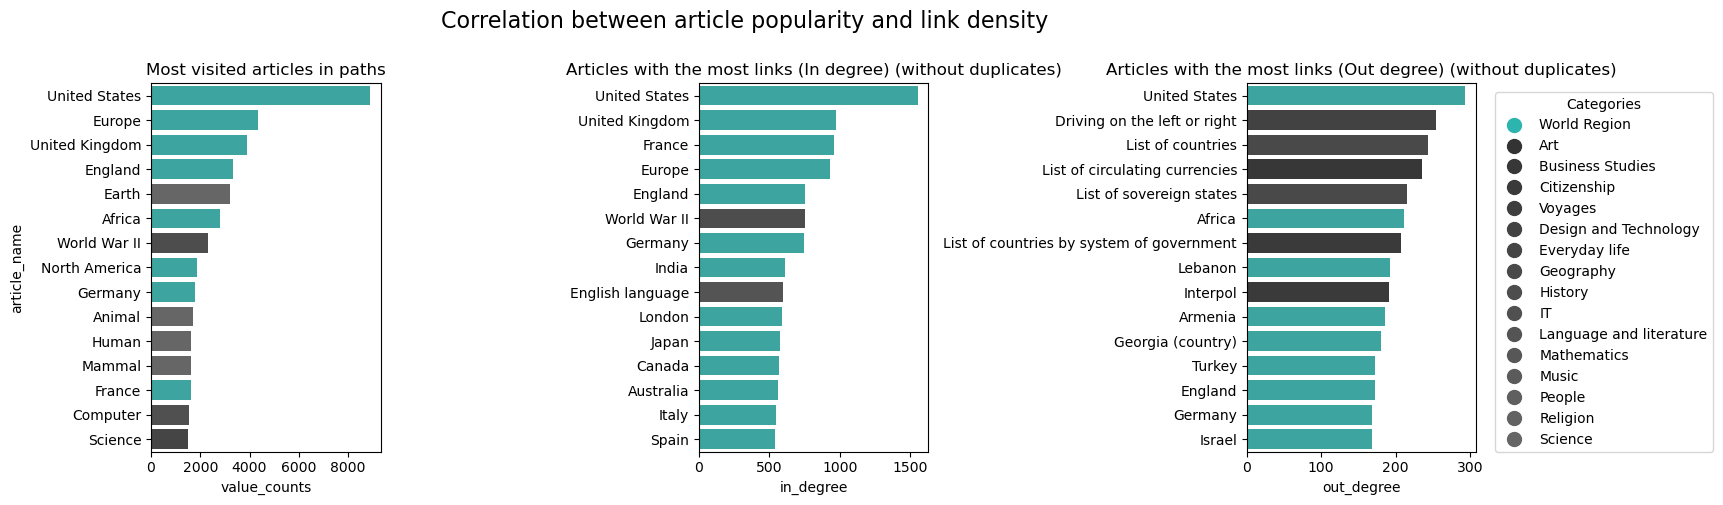

In [17]:
#TODO. comment + lists of countries in other categories
plot_article_popularity_link_density(df_article, df_finished, config.PALETTE_CATEGORY_DICT, config.CATEGORY_ABBREVIATIONS, df_categories)

Results : We observe a significant overlap between the most visited articles and those with the highest degree. Additionally, the "Countries" category is prominently represented.

## 3.2. Analyse user behaviour

Let's look for patterns in user behaviour and try to understand how we could measure whether a game was difficult or not. Many different metrics can be considered, for instance:
- Game duration
- Game path length
- Difficulty rating given for finished paths
- Number of back-clicks needed
- Whether a game was finished or not
- For unfinished games, how the game was abandoned

A combination of these parameters can help finding in which games users struggled. This will then allow to assess whether players struggle less in <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span> than in other paths.

Let's first have a look of how the difficulty measures are distributed amongst each other for finished paths.

### 3.2.a Path duration

The median duration of finished paths is 107 seconds
The median duration of all unfinished paths is 261 seconds, among which :
  - The median duration of restart paths is 114 seconds
  - The median duration of timeout paths is 1864 seconds
Kurtosis of finished game durations: 3982.55
Kurtosis of restart game durations: 45.47
Kurtosis of timeout game durations: 136.67


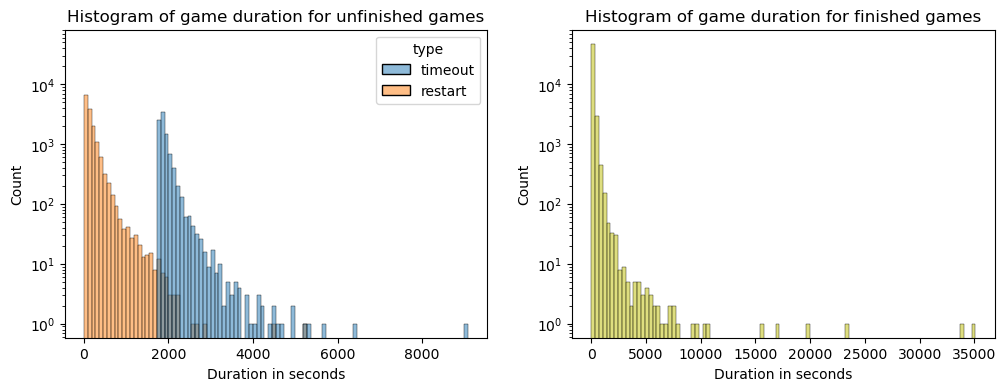

In [18]:
#TODO: keep code but not plot, not link to story

# Find medians and kurtosis for both finished and unfinished
median_finished = df_finished['durationInSec'].median()
kurtosis_finished = kurtosis(df_finished['durationInSec'])
median_unfinished = df_unfinished.groupby('type')['durationInSec'].median()
kurtosis_unfinished = df_unfinished.groupby('type')['durationInSec'].apply(kurtosis)

print(f"The median duration of finished paths is {median_finished:.0f} seconds")
print(f"The median duration of all unfinished paths is {df_unfinished['durationInSec'].median():.0f} seconds, among which :")
print(f"  - The median duration of restart paths is {median_unfinished['restart']:.0f} seconds")
print(f"  - The median duration of timeout paths is {median_unfinished['timeout']:.0f} seconds")

print(f"Kurtosis of finished game durations: {kurtosis_finished:.2f}")
print(f"Kurtosis of restart game durations: {kurtosis_unfinished['restart']:.2f}")
print(f"Kurtosis of timeout game durations: {kurtosis_unfinished['timeout']:.2f}")

# Plotting histograms
plt.figure(figsize=(12, 4))

# Unfinished games
ax1 = plt.subplot(121)
sn.histplot(df_unfinished, x='durationInSec', hue='type', bins=100)
plt.yscale('log')
plt.xlabel('Duration in seconds')
plt.title('Histogram of game duration for unfinished games')

# Finished games
plt.subplot(122, sharey=ax1)
sn.histplot(df_finished, x='durationInSec', bins=100, alpha=0.5, color='y')
plt.yscale('log')
plt.xlabel('Duration in seconds')
plt.title('Histogram of game duration for finished games')
plt.show()

Time-out paths are games where the player stopped playing for more that 30 minutes. If we set those aside, and look at the duration of paths where the players decided to restart a new game, the mediam duration of games is 114 seconds, approximately the same as finished path duration of 107 seconds.

The kurtosis in finished games is much higher than in unfinished restart games (3973 vs 45), meaning that finished games are more heavy tailed. We can in fact see very little players restart after 3000 seconds, whereas many finished games go beyond 6000. 

### 3.2.b Path duration and path length vs. user rating

Let's first look at path duration distribution over different user rating. We found similar results for finished and unfinished paths, so let's have a look at **finished ones** for example.

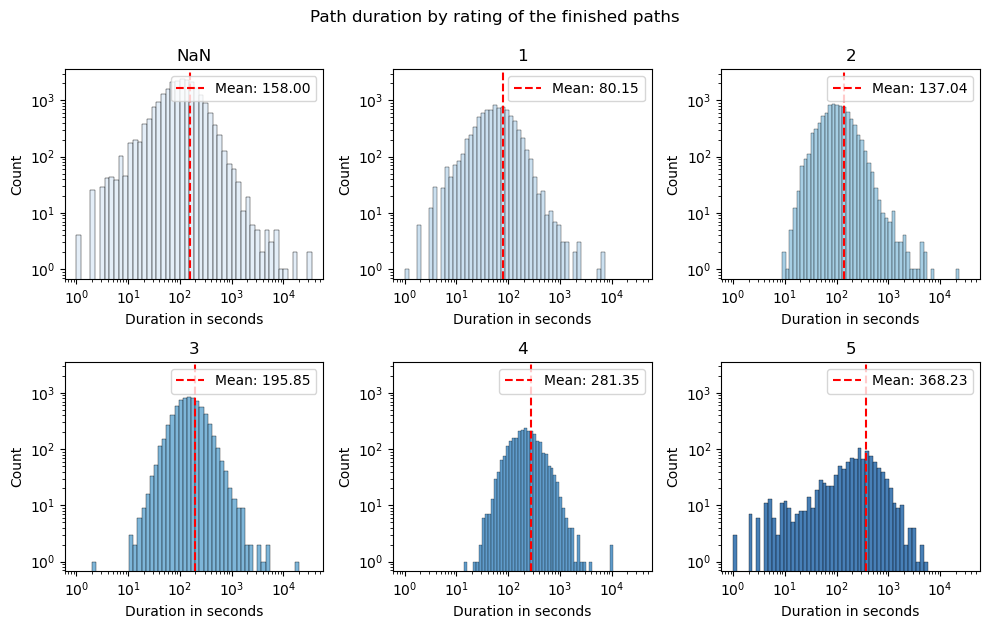

In [19]:
# change metric to 'path_length' for path length 
metric = 'durationInSec'

df_finished_strNaN = df_finished.copy()
df_finished_strNaN['rating'] = df_finished_strNaN['rating'].fillna('NaN')

plt.figure(figsize=(10, 6))
blues_palette = sn.color_palette("Blues", n_colors=6)

means, stds = [], []
ax1 = plt.subplot(231)
sn.histplot(df_finished[df_finished_strNaN['rating']=='NaN'], x=metric, bins=50, log_scale=True, color=blues_palette[0]) 
mean = df_finished[df_finished_strNaN['rating']=='NaN'][metric].mean()
plt.axvline(mean, color='red', label=f'Mean: {mean:.2f}', linestyle='--')
plt.yscale('log')
plt.xlabel('Duration in seconds')
plt.title('NaN')
plt.legend()

for i in range(1, 6):
    plt.subplot(231+i, sharex = ax1, sharey=ax1)
    sn.histplot(df_finished[df_finished_strNaN['rating']==i], x=metric, bins=50, log_scale=True, color=blues_palette[i])
    mean = df_finished[df_finished_strNaN['rating']==i][metric].mean()
    plt.axvline(mean, color="red", label=f'Mean: {mean:.2f}', linestyle='--')
    plt.yscale('log')
    plt.title(i)
    plt.xlabel('Duration in seconds')
    plt.legend()

plt.tight_layout()
plt.suptitle('Path duration by rating of the finished paths', y=1.04)
plt.show()

The distributions of the path duration by rating are nice log-normal distributions! This means we can use the mean (location) and standard deviation (scale) to characterise them. Indeed, except for NaN, there is a steady increase of the path duration mean when rating goes up.

Let's now look at whether path duration is correlated with path length:

In [20]:
df_path_stats_duration = pd.DataFrame()
df_path_stats_duration['mean'] = df_finished.groupby('rating', dropna=False)['durationInSec'].mean()
df_path_stats_duration['std'] = df_finished.groupby('rating', dropna=False)['durationInSec'].std()
df_path_stats_duration['sem'] = df_finished.groupby('rating', dropna=False)['durationInSec'].sem()

df_path_stats_length = pd.DataFrame()
df_path_stats_length['mean'] = df_finished.groupby('rating', dropna=False)['path_length'].mean()
df_path_stats_length['std'] = df_finished.groupby('rating', dropna=False)['path_length'].std()
df_path_stats_length['sem'] = df_finished.groupby('rating', dropna=False)['path_length'].sem()

df_path_stats = pd.concat([df_path_stats_duration, df_path_stats_length], axis=1, keys=['duration', 'length'])

df_path_stats

duration                            length                     
              mean         std        sem       mean        std       sem
rating                                                                   
1.0      80.150609  152.273618   1.648539   4.664909   2.052327  0.022219
2.0     137.036683  311.602204   3.325851   5.996355   2.432872  0.025967
3.0     195.847937  296.535832   3.483358   7.638057   3.699177  0.043454
4.0     281.351095  359.639492   6.870559  10.079927   5.871245  0.112164
5.0     368.231304  463.405289  13.665076  13.237391  17.200507  0.507215
NaN     158.002594  430.230937   2.852466   6.817486   4.030154  0.026720

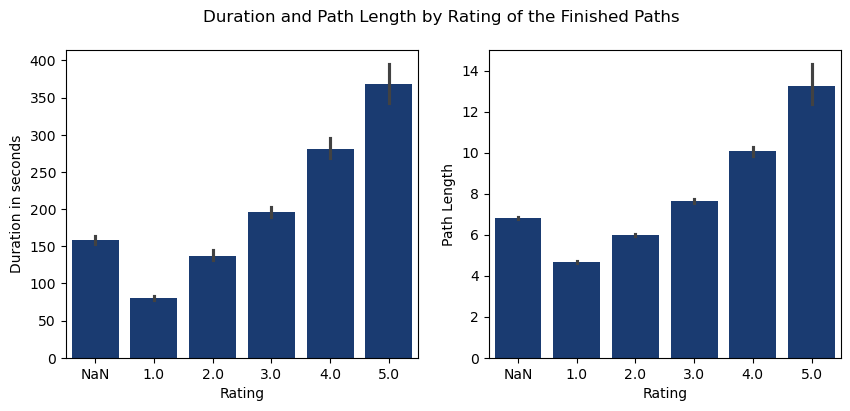

In [21]:
order = ['NaN', '1.0', '2.0', '3.0', '4.0', '5.0']

plt.figure(figsize=(10, 4))
plt.subplot(121)
sn.barplot(df_finished_strNaN, x='rating', y='durationInSec', order=order, errorbar=('ci', 95), color='#0b3880')
plt.xlabel('Rating')
plt.ylabel('Duration in seconds')
plt.subplot(122)
sn.barplot(df_finished_strNaN, x='rating', y='path_length', order=order, errorbar=('ci', 95), color='#0b3880')
plt.suptitle('Duration and Path Length by Rating of the Finished Paths')
plt.xlabel('Rating')
plt.ylabel('Path Length')
plt.show()

There is a clear correlation between how long players took or how many clicks they made with the experienced difficulty rating. This means we can easily combine the two into a difficulty measure as they agree with each other on what players considered difficult. 

Let's now loow at back-clicks: could it indicate whether players had a hard time?

### 3.2.c Back-clicks
The number of back-clicks made in a game may indicate players getting stuck.
Lets investigate how this metric is related with player ratings, and if they are more prominent in certain categories:

In [24]:
paths_finished = extract_category_path(df_finished, df_categories)
paths_finished = backtrack(paths_finished)

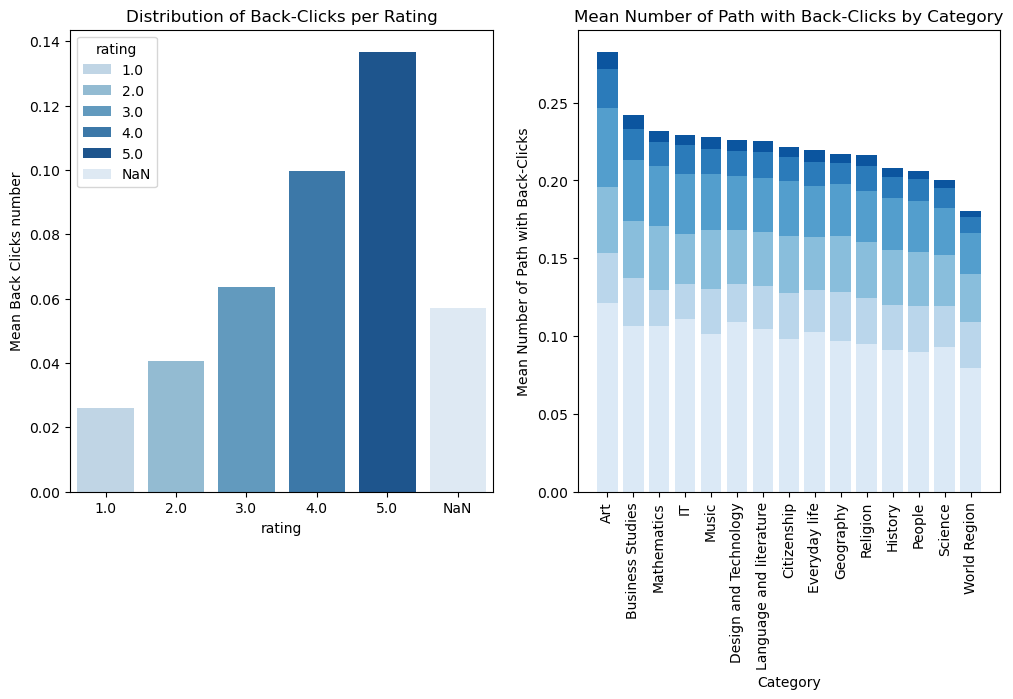

In [25]:
#TODO: a regrouper avec les plot de camille et autres metrics -> tous montrent un peu la meme conclusion, voyages ont un behaviour different

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

back_per_rating = paths_finished.groupby("rating", dropna=False).agg({"back_nb": "mean", "size": "mean"}).reset_index()
back_per_rating['Mean Back Clicks number'] = back_per_rating["back_nb"]/back_per_rating["size"]
back_per_rating['rating'] = back_per_rating['rating'].fillna('NaN')
sn.barplot(x="rating", y='Mean Back Clicks number', hue="rating", data=back_per_rating, palette=blues_palette[1:]+blues_palette[:1], ax=ax[0], legend=True)

df_exploded = paths_finished.explode('category')
category_back_mean = df_exploded.groupby(['category', 'rating'], dropna = False).size().reset_index(name='size')
back_mean = df_exploded.groupby('category')["have_back"].mean().reset_index().sort_values(by='have_back', ascending=False)
category_back_mean = category_back_mean.merge(back_mean, on='category').sort_values(by='have_back', ascending=False)
category_back_mean['rating_proportion'] = category_back_mean.groupby('category')['size'].transform(lambda x: x / x.sum())

order = category_back_mean["category"].unique()
base_heights = category_back_mean[['category', 'have_back']].drop_duplicates().set_index('category')['have_back']
df_pivot = category_back_mean.pivot(index='category', columns='rating', values='rating_proportion').fillna(0)
df_pivot = df_pivot.reindex(order)

bottom = pd.Series([0] * len(df_pivot), index=df_pivot.index)
for i, rating in enumerate(df_pivot.columns):
    ax[1].bar(df_pivot.index, 
           height=df_pivot[rating] * base_heights,  
           bottom=bottom * base_heights,           
           label=f'Rating {rating}', 
           color=blues_palette[i])
    bottom += df_pivot[rating]

ax[1].set_title('Mean Number of Path with Back-Clicks by Category')
plt.xlabel('Category')
plt.ylabel('Mean Number of Path with Back-Clicks')
plt.xticks(rotation=90)
ax[0].set_title("Distribution of Back-Clicks per Rating")
plt.show()

The back-clicks are correlated with the difficulty rating, which is expected as the more difficult a game is, the more likely players are to get stuck and go back.
The category with the most back-clicks is "Art", and the one with the least is "Countries". This is interesting as "Countries" is also one of the most visited category, which might indicate that players are more familiar with it and therefore less likely to get stuck.
Additionaly, The distribution of rating inside each category seams quite similar.

In [22]:
plot_difficulties_voyage(df_finished, df_unfinished, config.PALETTE_CATEGORY_DICT)

In [26]:
paths_finished.groupby(["Wikispeedia_Voyage"])["back_clicks"].mean().reset_index()

,Wikispeedia_Voyage,back_clicks
0,False,0.306766
1,True,0.535299


Voyage paths tend to be longer than non-voyage paths, with more back-clicks and a slightly higher rating. However, the percentage of completed games is higher for Voyages compared to Non-Voyages.

While World Regions articles are relatively few in number, they are highly prevalent within the network, often serving as key intermediate steps in paths. Although the 'Voyage' paths seem effective, they tend to be slower and less efficient overall. Is the popularity of these articles solely due to this? Could it be that users intentionally choose these articles? Further investigation is needed to explore this.

## 3.3 Look at articles as a categories types

### 3.3.a Categories Distributions
! Interactive plots with plotly need the notebook to be run but were replaced with screenshots for convenience. !

In [27]:
# Needed because in the read_all and for previous visualizations we already selected the most specific categories
df_categories_original = read_categories()

In [28]:
labels, parents, values, ids = create_treemap_data(df_categories_original)
fig = go.Figure(go.Treemap(
    labels=labels,
    parents=parents,
    values=values,
    ids=ids,
    textfont=dict(size=18),
))
fig.update_layout(margin=dict(t=50, l=10, r=10, b=5), title="Category Distribution in Articles Counting Every Category for Each Article")
fig.show()

![alt text](./figures/33a.png)

In [29]:
print(f'We have {df_categories_original["level_1"].unique().size} distinct level 1 categories.')

We have 15 distinct level 1 categories.


- Each category is organized into multiple sub-levels, with a hierarchical depth of up to 3 levels.

- For this analysis, we will focus exclusively on the most superficial level: Level 1.

- Additionally, we observe that some articles are associated with multiple categories, highlighting overlaps and shared connections within the dataset.

#### Articles with Multiples Categories

- First we count the numbers of articles with multiples categories:

In [30]:
# Count the number of articles with multiples categories
df_categories_original.groupby("article")["article"].size().value_counts()

article
1    3986
2     590
3       8
Name: count, dtype: int64

- But if we constrain it only to different type of level 1 categories, it is reduced to :

In [31]:
# Count the number of unique level 1 categories per article
df_categories_original.groupby("article")["level_1"].nunique().value_counts()

level_1
1    4078
2     505
3       1
Name: count, dtype: int64

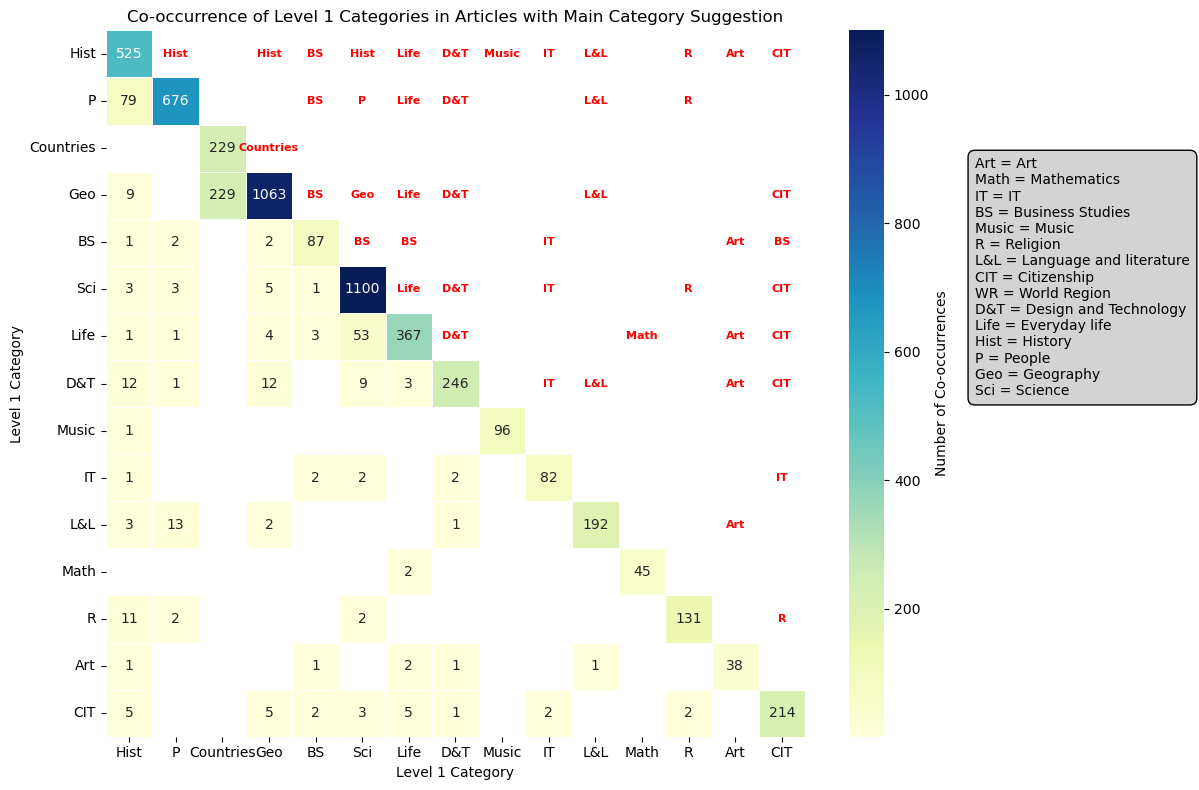

In [32]:
plot_cooccurrence_cat_matrix(df_categories_original, config.CATEGORY_ABBREVIATIONS)

Attributing the **main category** to articles with multiple categories based on the category **with fewer total articles** helps prioritize specialization over generality. 

Categories with fewer total articles are typically more specific, while those with higher counts cover broader topics. By focusing on the category with fewer articles, we ensure the article’s primary focus is on a unique or specialized perspective, providing a clearer thematic assignment. This method promotes a balanced classification system, ensuring articles are categorized accurately without being overshadowed by more general categories.

- For example, a category like **"Geography"** may encompass a wide range of topics, while **"Countries"** might be more specialized.

In [33]:
##TODO: Info so now here we explain about the most specific categories + the new categories we created: world regions to show it?
## Maybe do these exploration better at the beginning of the notebook to explain the categories and the new ones we created?

In [34]:
#TODO: add subcategories

labels_filtered, parents_filtered, values_filtered, ids_filtered = create_treemap_data(df_categories)
fig = go.Figure(go.Treemap(
    labels=labels_filtered,
    parents=parents_filtered,
    values=values_filtered,
    ids=ids_filtered,
    textfont=dict(size=18),
))

fig.update_layout(margin=dict(t=50, l=10, r=10, b=5), title="Category Distribution in Articles (Only the most specific category is shown for each article)")
fig.show()

![alt text](./figures/33a1.png)

### 3.3.b Transitions between categories

We decide to merge the finished and unfinished paths as in this section we will first only analyse how users make moves between categories of articles, independ of their succes on the research.

In [35]:
#TODO: a enlever et remplacer par le graph network

While this is not the best way to visualise transitions between categories (this comes a bit later with graphs), it gives some important numerical values as first overview. Certain transitions seem to be more prominent than others, such as transitions from Geography to Countries or clicks to remain in Science. Generally, a lot of paths lead to Countries and Geography. Back-clicks, History and Science also have an overall strong presence. Does this give any real information about transitions users like or is it simply due to how many articles there are for the analysed categories?

KeyError: 'Others'

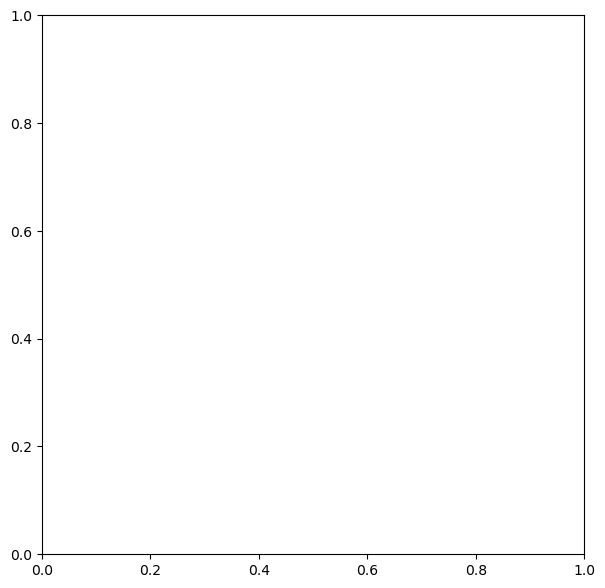

In [36]:
plot_articles_pie_chart(df_categories, config.PALETTE_CATEGORY_DICT, config.CATEGORY_ABBREVIATIONS)

Geography is both a category that many articles have and a category with high transitions. This needs to be further analysed to see if users really choose to go through Geography or if they are just more likely to find an article with that category. The same cannot be said for Countries, which is a much smaller category which still has high transition counts!

#### Transitions within categories (excluding self-category)

Let's remove the transitions in early articles that stay in the same category: if a player wants to leave a category but does not find an adequate link, we will only consider the next different category as next step.

For example :
- Science -> Science -> Science **becomes** Science
- Science -> Science -> Science -> Citizenship -> Design and Technology **becomes** Science -> Citizenship -> Design and Technology

In [ ]:
common_paths_nl = analyze_categories_paths(df_merged, df_categories, omit_loops=True)

In [ ]:
df_position_data = get_position_frequencies(common_paths_nl, max_position=15)
plot_position_line(df_position_data, df_article, title="Position Frequencies for Finished Paths")

![alt text](./figures/33a3.png)

We can see that the categories in the early path positions are very often Countries or Geography. A lot of paths start in Science, but players seem to either leave in the first steps or stay there for the rest of the path. Very few start in Countries, but this category seems to be the most popular one to go to as a second step. For Geography, the trend is less clear but players still rather join the category than leave it in the second step.

One last interesting analysis is that back-clicks seem to gain popularity as the paths get longer!

### Comparison with optimal paths

Let's define the optimal path as the shortest path that can be taken. This assumption is coherent since the goal of the game is to reach the target while keeping the number of clicks as low as possible.

We can analyze whether users’ choice of categories aligns with the categories in the optimal path to determine if passing through 'Voyages' is an effective strategy for reaching the target.

To achieve this, we first need to compute the optimal path by constructing a directed graph where edges represent connections between articles. Here we take all the shortest possible paths per each combinaton of source-target present in the users' games. 

In [ ]:
optimal_paths = find_all_source_target_pairs(df_finished, df_unfinished, df_links)
optimal_paths = calculate_optimal_path(df_links, optimal_paths, df_shortest_path)

Some combination of source and target have many possible shortest paths!

In [ ]:
# Count the number of shortest paths for each (source, target) combination
path_counts = optimal_paths.groupby(['source', 'target']).size().reset_index(name='path_count')
path_counts.sort_values(by='path_count')

In [ ]:
opt_paths = analyze_categories_paths(optimal_paths, df_categories, users=False, omit_loops=False)
df_position_opt_data = get_position_frequencies(opt_paths, max_position=15)
plot_position_line(df_position_opt_data, df_article, title="Position Frequencies for Optimal Paths")

Indeed, <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span> seem to often be the ideal algorithmic path. This is interesting, but in the future we will need to also compare <i>human</i> best performance with the voyages to draw a conclusion.

In [ ]:
# Map the paths artciles to their categories
optimal_paths['path_categories'] = optimal_paths['path'].apply(lambda path: map_path_to_categories(path, category_map))

# Get users paths mapped to categories
users_finished, users_unfinished = users_paths(df_finished, df_unfinished, category_map)
# Filter optimal paths to match source-target pairs in users paths
optimal_fin, users_finished, optimal_unf, users_unfinished = filter_pairs(optimal_paths, users_finished, users_unfinished)

To compare user paths with optimal paths, we calculate the percentage of times each category is visited at each step for both datasets and each source-target association. To examine general trends, we average these percentages across steps for each category. Next, we compute the difference between the optimal and user paths for each source-target association and category.

We can average these differences directly across all associations or first group them by source-target category pairs (e.g., source in 'Art' and target in 'Music'), then average within these groups to balance category representation. This analysis applies to both finished and unfinished user paths.

In [ ]:

S_T_opt_fin_percentages, S_T_fin_percentages, S_T_opt_unf_percentages, S_T_unf_percentages = calculate_step_percentages(optimal_fin, users_finished, optimal_unf, users_unfinished)

# Data processing steps
dataframes = [
    (S_T_opt_fin_percentages, 'opt'),
    (S_T_fin_percentages, 'fin'),
    (S_T_opt_unf_percentages, 'opt'),
    (S_T_unf_percentages, 'unf')
]
key_columns = ['source', 'target', 'categories']

# Calculate averages and rename columns
S_T_opt_fin_avg, S_T_fin_avg, S_T_opt_unf_avg, S_T_unf_avg = calculate_average_percentages(
    dataframes,
    column_names=['source', 'target', 'categories', 'percentage']
)

# Merge and calculate differences
S_T_diff_fin = merge_and_calculate_difference(S_T_opt_fin_avg, S_T_fin_avg, key_columns, ('percentage_fin', 'percentage_opt'))
S_T_diff_unf = merge_and_calculate_difference(S_T_opt_unf_avg, S_T_unf_avg, key_columns, ('percentage_unf', 'percentage_opt'))

# Process data for both finished and unfinished paths
category_fin_means, category_fin_means_norm = process_category_means(S_T_diff_fin, category_map)
category_unf_means, category_unf_means_norm = process_category_means(S_T_diff_unf, category_map)


In [ ]:
# Combine datasets for bar plot
category_fin_means['path'] = 'finished'
category_unf_means['path'] = 'unfinished'
concat_means = pd.concat([category_fin_means, category_unf_means])

# Plot
plt.figure(figsize=(10, 6))
sn.barplot(x='categories', y='percentage_diff', hue='path', data=concat_means)
plt.xlabel('Categories')
plt.ylabel('Average percentage difference')
plt.title('Average percentage difference by category')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

In [ ]:
#TODO: a mettre ensemble avec les deux autres

# Combine datasets for bar plot
category_fin_means_norm['path'] = 'finished'
category_unf_means_norm['path'] = 'unfinished'
concat_means_norm = pd.concat([category_fin_means_norm, category_unf_means_norm])

# Plot
plt.figure(figsize=(10, 6))
sn.barplot(x='categories', y='percentage_diff', hue='path', data=concat_means_norm)
plt.xlabel('Categories')
plt.ylabel('Average percentage difference')
plt.title('Average percentage difference by category - normalized')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

The plot clearly shows that users pass through 'Voyages' less often than optimal paths suggest. This finding was surprising, as we intuitively expected humans to use more  <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span> than necessary. However, the opposite is true. Users might benefit from utsing this category more, likely because, as shown earlier, it is highly interconnected with other categories.

### Comparison with random path

In [ ]:
#TODO: replace with markov, regrouper par categories comme plot avant

### Page structure

In [ ]:
# where are link to a certain category in a page ?
link_per_cat = find_category_position_articles(parser, df_categories, config.CATEGORIES_OTHERS)
df = pd.DataFrame(link_per_cat)
df.describe()

In [ ]:
# Where do people click on an article page ?
df_finished_voyage = location_click_on_page(df_finished, parser)
df_unfinished_voyage = location_click_on_page(df_unfinished, parser)
all_paths = pd.concat([df_finished_voyage, df_unfinished_voyage])

In [ ]:
all_paths["category"] = "All"
all_paths["Legend :"] = "Clicked Link Position in Paths"
df_melted = pd.melt(df, var_name='category', value_name='position').dropna()
df_melted["Legend :"] = "Article Link Position in Articles"
df_comparison_path_category = pd.concat([all_paths[["category", "position", "Legend :"]], df_melted])

fig = px.box(df_comparison_path_category, x="category", y="position", color="Legend :", title="Position of the clicked link in articles compared to position of each category in articles")
fig.update_xaxes(tickangle=45)

fig.update_layout(
    autosize=False,
    width=1500,
    height=500,
    boxgroupgap=0.2, # update
    boxgap=0)
fig.show()

### 3.3.c Networks

Here, we create a network *(directed graph)* to represent user transitions between different categories of articles.

- **Nodes:** Each node represents a group of articles belonging to a specific category, with each article assigned to his main category. 
- **Edges:** Each edge represents a transition from one article category to another, indicating the flow of user activity.

In this visualization, we exclude transitions within the same category (self-loops), as these are already represented in the transition matrix shown earlier (3.3.b). The focus here is on how users navigate between different categories.

The node positions are determined using a **force-directed algorithm**:

- Nodes repel each other like charged particles, preventing overlaps.
- Edges act like springs, pulling connected nodes closer to reflect their relationships.

----------


In the cell below, we recursively replace each back click **(<)** with the article that was visited prior to it. This ensures that we accurately reconstruct the original navigation path and correctly identify the corresponding category for each step.

In [ ]:
df_merged_no_backclick = df_merged['path'].apply(replace_back_clicks)
G = build_network(df_merged_no_backclick, df_categories, include_self_loops=False)
G = filter_network(G, weight_threshold=7, top_n=6)
plot_network(G, df_categories,palette=config.PALETTE_CATEGORY_DICT, title="Network of transitions whithin Categoires", show_edge_labels=False, node_size=1000, node_abbreviations=category_abbreviations)

We observe a clustered graph, with central clusters dominated by categories containing the largest number of articles, such as Science, Geography, People, and History. Additionally, we see Countries positioned close to the center,despite the small size of the category (only 5% of the total articles) reflecting its strong connections with these major categories.

Next, we will normalize the edge weights by the total number of articles in the **source** category. This adjustment accounts for the imbalance in category sizes, ensuring a more accurate representation of transition dynamics.

**Note:** Currently, we are normalizing by the size of the source node only. However, for future analyses, we plan to explore other normalization methods, such as accounting for the size of the target category.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='rating', 
                                                    aggfunc='mean')

sn.heatmap(path_finished_length_categories , cmap='Greens', square=True)
plt.title("Heatmap of rating for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

Some category combinations seem to be harder than others: Countries to Art of Mathematics to Religion seem to pose problems to players, while paths inside a category (the diagonal) seem to be generally perceived as easier.

# 4. Methods for Further Analysis
This section aims to show a few of the tools that will be useful along the way for our project. Instead of using them to answer our final question, we use them on the dataset as a whole to show that interesting information can be extracted from these methods.

We can clearly see that the reordered article indices make intuitive sense, similar words are regrouped. Words in the clusters with high similarity (similarity > 0.5) are words that appear more often in natural language, while words in the low-similarity areas are similar one to another, but not commonly used. This shows that we can regroup articles in clusters of 'well-known words' that are likely more present on user paths.

## 4.2. Evolution of similarity on paths
Now that we established similarity as a metric, can we see how mean similarity evolves on paths in general? Do we observe that users quickly try to leave a category in the first few clicks? Later this will be used to assess whether there is a difference for voyages and non-voyages, and whether there is a difference depending on the categories the path in made of, but for now this already gives an insight into what we can expect.

In [ ]:
#TODO: test si interessant avec voyages, check with jaccard, add to camille results, could check other embedding

all_finished_paths = [replace_back_clicks(path).split(';') for path in df_finished['path'].tolist()]
path_similarities = []

for path in all_finished_paths:
    path_similarity = []
    for step in range(len(path)-1):
        current, next = path[step], path[step+1]
        path_similarity.append(df_sm[current][next])

    path_similarities.append(path_similarity)

Here is an example to understand what is going on. Each point represents a click of a user, to go from the first page (Batman) to the next (Chemistry). Batman and Chemistry are not strongly semantically related (hence the relatively low value of about 0.4). In the next step to Biology, the similarity is much higher (about 0.7), so the player first leave the category to reach the target category and then tends to stay there.

In [ ]:
path_id = 1829
path = path_similarities[path_id]
plt.plot(range(len(path)), path, marker='o', color='#0c8714')
plt.xticks([i-0.5 for i in range(len(path)+1)], all_finished_paths[path_id], rotation=90)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
len_N_path_similarity = {}
for path_sim in path_similarities:
    path_length = len(path_sim)
    len_N_path_similarity.setdefault(path_length, []).append(path_sim)

len_N_mean_similarity = {paths_len: np.mean(paths, axis=0) for paths_len, paths in len_N_path_similarity.items()}

In [ ]:
plt.figure(figsize=(7, 5))
greens_palette = sn.light_palette("#0c8714", n_colors=10)

for i in range(1, 11):
    sn.lineplot(len_N_mean_similarity[i+1], lw=1, label=i, color=greens_palette[i-1])
plt.legend(title='# Link Clicks')
plt.xlabel("Position of the Click in the Players' Paths")
plt.xticks(range(0, 11))
plt.ylabel('Mean Semantic Similarity')
plt.title('Mean Semantic Similarity Difference Aggregated by Path Lenghts')
plt.tight_layout()
plt.show()

There is a clear trend: in the first few clicks, the articles chosen have a low similarity to the previous one: this can be interpreted as leaving the original category. After this, the similarity for the next clicks stabilises, with only small fluctuations.